In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras import layers, models




2024-09-19 13:09:48.950138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# CIC dataset
anomaly_df = pd.read_csv('CIC_anomaly_sampled.csv')
anomaly_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1494,26,1,1,0,6,0,0,0.000000,0.000000,...,40,0.0,0.0,0,0,0.0,0.0,0,0,PortScan
1,80,82251299,9,7,62,11601,20,0,6.888889,5.301991,...,20,1444970.0,0.0,1444970,1444970,80300000.0,0.0,80300000,80300000,DDoS
2,80,84119742,8,4,56,11601,20,0,7.000000,5.656854,...,20,5.0,0.0,5,5,42000000.0,43600000.0,72800000,11200000,DDoS
3,2998,15,1,1,2,6,2,2,2.000000,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,PortScan
4,3369,49,1,1,2,6,2,2,2.000000,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,PortScan


In [3]:
anomaly_df[' Destination Port'].value_counts()

 Destination Port
80       44975
444        107
443         84
22          82
264         75
         ...  
5901        14
2000         9
0            4
123          1
27636        1
Name: count, Length: 1001, dtype: int64

In [4]:
benign_df = pd.read_csv('CIC_benign_sampled.csv')
benign_df.shape

(146660, 79)

In [5]:
benign_df[' Destination Port'].value_counts()

 Destination Port
53       58295
443      27169
80       15352
123       1205
22         717
         ...  
50318        1
65325        1
39161        1
42056        1
34928        1
Name: count, Length: 22035, dtype: int64

In [6]:
df = pd.concat([benign_df,anomaly_df]).sample(frac=1, random_state=42).reset_index(drop = True)
df.shape

(244490, 79)

In [7]:
string_columns = df.select_dtypes(include=['object']).columns
print(string_columns)

Index([' Label'], dtype='object')


In [8]:
columns = list(df.columns)
for i in range(len(columns)):
    if columns[i][:1] == ' ':
        l = len(columns[i])
        columns[i] = columns[i][1:l+1]

df.columns = columns

In [9]:
import re
pattern = re.compile(r'port', re.IGNORECASE)

# Filter and print items that contain 'port'
for item in columns:
    if pattern.search(item):
        print(item)

Destination Port


In [11]:
df['Label'].value_counts()

Label
BENIGN                        146660
PortScan                       52939
DDoS                           42675
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Name: count, dtype: int64

In [12]:
df['Destination Port'].value_counts()

Destination Port
80       60327
53       58352
443      27253
123       1206
22         799
         ...  
60303        1
56194        1
50681        1
9542         1
1456         1
Name: count, Length: 22036, dtype: int64

In [47]:
def categorize_port(port):
    if port <= 1023:
        # well known
        return 'well-known'
    elif port <= 49151:
        # 
        return 'registered'
    else:
        return 'dynamic'
    

df['port_category'] = df['Destination Port'].apply(categorize_port)

df.drop('Destination Port', axis = 1, inplace=True)
df.head()

KeyError: 'Destination Port'

In [48]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the 'port_category' column
ohe = OneHotEncoder(sparse_output=False)
encoded_port_categories = ohe.fit_transform(df[['port_category']])

# Convert the encoded data into a DataFrame
# Modify the column names to remove brackets and commas
encoded_column_names = [f'port_category_{str(cat)}' for cat in ohe.categories_[0]]
encoded_df = pd.DataFrame(encoded_port_categories, columns=encoded_column_names)

# Concatenate the one-hot encoded columns with the original DataFrame
df_onehot = pd.concat([df, encoded_df], axis=1)


In [49]:
df_onehot.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,port_category,port_category_dynamic,port_category_registered,port_category_well-known
0,10000147,5,8,12976,50,5840,0,2595.2,2976.615981,20,...,56472,9528546.0,0.0,9528546,9528546,BENIGN,dynamic,1.0,0.0,0.0
1,11,1,1,0,6,0,0,0.0,0.000000,6,...,0,0.0,0.0,0,0,PortScan,registered,0.0,1.0,0.0
2,490,1,1,60,115,60,60,60.0,0.000000,115,...,0,0.0,0.0,0,0,BENIGN,well-known,0.0,0.0,1.0
3,5067656,1,5,6,30,6,6,6.0,0.000000,6,...,35541,5032115.0,0.0,5032115,5032115,BENIGN,dynamic,1.0,0.0,0.0
4,7842890,5,0,30,0,6,6,6.0,0.000000,0,...,2004,7840886.0,0.0,7840886,7840886,DDoS,well-known,0.0,0.0,1.0


In [50]:
df_onehot.drop(['port_category'], axis = 1, inplace=True)

In [51]:
df_onehot.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,port_category_dynamic,port_category_registered,port_category_well-known
0,10000147,5,8,12976,50,5840,0,2595.2,2976.615981,20,...,56472,56472,9528546.0,0.0,9528546,9528546,BENIGN,1.0,0.0,0.0
1,11,1,1,0,6,0,0,0.0,0.000000,6,...,0,0,0.0,0.0,0,0,PortScan,0.0,1.0,0.0
2,490,1,1,60,115,60,60,60.0,0.000000,115,...,0,0,0.0,0.0,0,0,BENIGN,0.0,0.0,1.0
3,5067656,1,5,6,30,6,6,6.0,0.000000,6,...,35541,35541,5032115.0,0.0,5032115,5032115,BENIGN,1.0,0.0,0.0
4,7842890,5,0,30,0,6,6,6.0,0.000000,0,...,2004,2004,7840886.0,0.0,7840886,7840886,DDoS,0.0,0.0,1.0


In [52]:
X = df_onehot.drop(columns = ['Label'])
y = pd.DataFrame(columns = ['Label'])
y['Label'] = df_onehot['Label']

In [43]:
y.head()

,Label
0,BENIGN
1,PortScan
2,BENIGN
3,BENIGN
4,DDoS


In [53]:

y['Label'] = y['Label'].apply(lambda x: 0 if x=='BENIGN' else 1)
# OR type doesn't change since pandas changes list back to dataframe
# y['Label'] = [0  if item == 'BENIGN' else 1 for item in y['Label']]


In [54]:
'''
stratify=y in the train_test_split function is to ensure that 
the class distribution of the target variable (y) is 
maintained across the training, validation, and test sets.
'''

# First, split into train+validation and test (e.g., 85% train+validation, 15% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Now split the train+validation into train and validation sets (e.g., 75% train, 25% validation of the 80%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Final shapes of each set
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (155862, 80), Validation Set: (51954, 80), Test Set: (36674, 80)


In [55]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 
pca = PCA(n_components = 0.95, random_state = 42)
X_train_pca = pca.fit_transform(X_train_scaled)


# For validation and test data (Using the same scaler and pca):
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [56]:
X_train_pca.shape

(155862, 24)

In [57]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2024-09-19 13:44:47.288953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 13:44:47.337616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 13:44:47.338021: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## FOR RNN

In [59]:
# reshape input to be [samples, time steps, features]
X_train_reshaped = X_train_pca.reshape((X_train_pca.shape[0], 1, X_train_pca.shape[1]))
X_val_reshaped = X_val_pca.reshape((X_val_pca.shape[0], 1, X_val_pca.shape[1]))

# Converting into tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_reshaped, y_val))

# Using the batch size = 32 and batching
batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_reshaped)).batch(batch_size)
val_dataset =val_dataset.shuffle(buffer_size=len(X_val_reshaped)).batch(batch_size)

# prefetching
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

2024-09-19 13:45:24.987032: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29925504 exceeds 10% of free system memory.
2024-09-19 13:45:25.021381: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29925504 exceeds 10% of free system memory.


In [60]:
X_train_reshaped.shape, X_val_reshaped.shape, y_train.shape, y_val.shape

((155862, 1, 24), (51954, 1, 24), (155862, 1), (51954, 1))

In [61]:
in_shape = X_train_reshaped[0].shape
model = models.Sequential([
    layers.Input(shape=in_shape),  # Input layer
    layers.GRU(4),                # GRU layer with 4 units
    layers.Dropout(0.1),          # Dropout layer with 10% dropout rate
    layers.Dense(1, activation = 'sigmoid'),  
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 4)              │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365 (1.43 KB)

 Trainable params: 365 (1.43 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [63]:
epochs = 20
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/20


2024-09-19 13:45:57.236098: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29925504 exceeds 10% of free system memory.
2024-09-19 13:45:59.867814: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


2436/2436 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7744 - loss: 0.4350 - val_accuracy: 0.9690 - val_loss: 0.1228
Epoch 2/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9629 - loss: 0.1243 - val_accuracy: 0.9707 - val_loss: 0.0980
Epoch 3/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9665 - loss: 0.1060 - val_accuracy: 0.9718 - val_loss: 0.0904
Epoch 4/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9683 - loss: 0.0970 - val_accuracy: 0.9737 - val_loss: 0.0867
Epoch 5/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9688 - loss: 0.0951 - val_accuracy: 0.9730 - val_loss: 0.0848
Epoch 6/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9701 - loss: 0.0885 - val_accuracy: 0.9731 - val_loss: 0.0817
Epoch 7/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9711 - loss: 0.0904 - val_accuracy: 0.9740 - val_loss: 0.0801
Epoch 8/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9719 - loss: 0.0877 - val

In [64]:
model.save("rnn_cic1.keras")

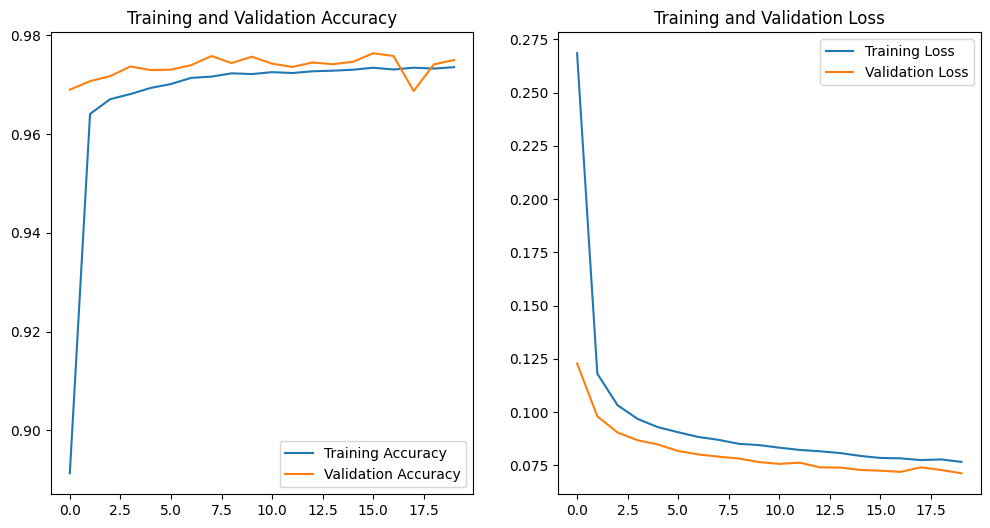

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = [i for i in range(len(acc))]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('rnn_cic.png')
plt.show()

## Testing

In [67]:
X_test_pca.shape

(36674, 24)

In [70]:
X_test_reshaped = X_test_pca.reshape((X_test_pca.shape[0], 1, X_test_pca.shape[1]))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_reshaped, y_test))

batch_size = 32
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [71]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9764 - loss: 0.0678
Test Loss: 0.069638691842556
Test Accuracy: 0.975841224193573


In [79]:
predictions = model.predict(test_dataset)

# If you want to see some predictions
for i, pred in enumerate(predictions[:5]):  # Displaying the first 5 predictions
    print(f'Prediction {i+1}: {pred}')

   1/1147 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step

1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Prediction 1: [0.00302019]
Prediction 2: [0.99986637]
Prediction 3: [1.6625337e-06]
Prediction 4: [0.821182]
Prediction 5: [0.999974]


In [78]:
print(f'Predictions range: {predictions.min()} to {predictions.max()}')


Predictions range: 7.015792391484865e-08 to 0.999997615814209


In [73]:
y_test[:5]

,Label
184229,0
211022,1
35457,0
145955,1
18792,1


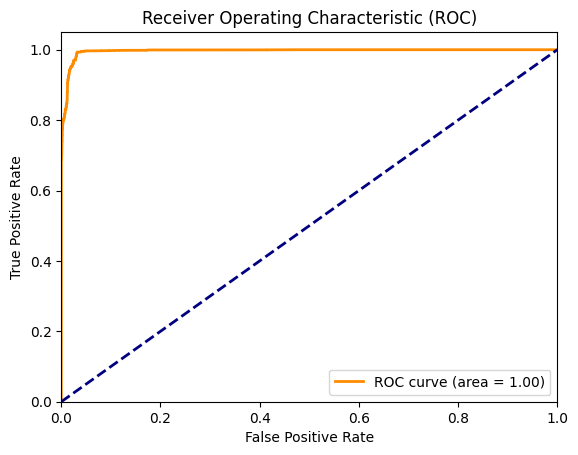

In [80]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Step 4: Compute AUC (Area Under Curve) - Higher is better
roc_auc = auc(fpr, tpr)

# Step 5: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('CIC_RNN_ROC.png')
plt.show()

In [81]:
# Compute Youden's J statistic to find the optimal threshold
j_scores = tpr - fpr
best_threshold_index = np.argmax(j_scores)
best_threshold = thresholds[best_threshold_index]

print(f'Best Threshold (Maximizing TPR - FPR): {best_threshold:.2f}')

Best Threshold (Maximizing TPR - FPR): 0.54


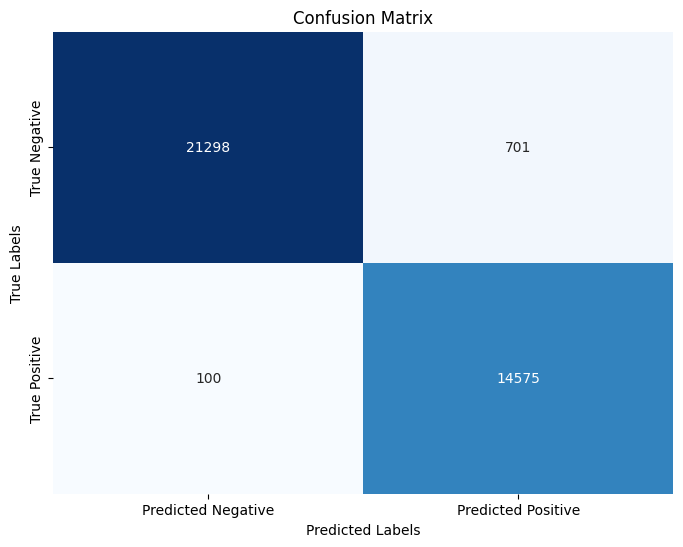

In [82]:
predicted_classes = np.where(predictions >= best_threshold, 1, 0)
cm = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('rnn_all_confusion_matrix.png')
plt.show()

In [84]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
tn, fp, fn, tp = cm.ravel()

# Compute Metrics
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)
accuracy = accuracy_score(y_test, predicted_classes)
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# Print metrics
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Specificity: {specificity:.2f}')

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, predicted_classes))

Precision: 0.95
Recall: 0.99
F1 Score: 0.97
Accuracy: 0.98
Specificity: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     21999
           1       0.95      0.99      0.97     14675

    accuracy                           0.98     36674
   macro avg       0.97      0.98      0.98     36674
weighted avg       0.98      0.98      0.98     36674



## For CNN

In [98]:
# reshape input to be [samples, time steps, features]
X_train_reshaped_cnn = X_train_pca.reshape((X_train_pca.shape[0],X_train_pca.shape[1],1))
X_val_reshaped_cnn = X_val_pca.reshape((X_val_pca.shape[0], X_val_pca.shape[1],1))

# Converting into tensors
train_dataset_cnn = tf.data.Dataset.from_tensor_slices((X_train_reshaped_cnn, y_train))
val_dataset_cnn = tf.data.Dataset.from_tensor_slices((X_val_reshaped_cnn, y_val))

# Using the batch size = 64 and batching
batch_size = 64
train_dataset_cnn = train_dataset_cnn.shuffle(buffer_size=len(X_train_reshaped_cnn)).batch(batch_size)
val_dataset_cnn =val_dataset_cnn.shuffle(buffer_size=len(X_val_reshaped_cnn)).batch(batch_size)

# prefetching
train_dataset_cnn = train_dataset_cnn.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset_cnn = val_dataset_cnn.prefetch(tf.data.experimental.AUTOTUNE)

In [92]:
X_train_reshaped_cnn.shape

(155862, 24, 1)

In [99]:
i_shape = X_train_reshaped_cnn[0].shape

cnn_model = models.Sequential()

# First Conv layer
cnn_model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=i_shape))

# Second Conv layer
cnn_model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))

# Third Conv layer
cnn_model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))

# Fourth Conv layer
cnn_model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))

# Fifth Conv layer
cnn_model.add(layers.Conv1D(filters=512, kernel_size=3, activation='relu'))

# First MaxPool layer
cnn_model.add(layers.MaxPooling1D(pool_size=2))

# Second MaxPool layer
cnn_model.add(layers.MaxPooling1D(pool_size=2))

# Flatten the output before Fully Connected layers
cnn_model.add(layers.Flatten())

# First Fully Connected (Dense) layer
cnn_model.add(layers.Dense(256, activation='relu'))

# Second Fully Connected (Dense) layer
cnn_model.add(layers.Dense(128, activation='relu'))

# Third Fully Connected (Dense) layer
cnn_model.add(layers.Dense(64, activation='relu'))

# Fourth Fully Connected (Dense) layer
cnn_model.add(layers.Dense(32, activation='relu'))
# Output layer with SoftMax for classification
cnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
cnn_model.summary()

/home/mejan/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 22, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 20, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 18, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 16, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 14, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 7, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 960,065 (3.66 MB)

 Trainable params: 960,065 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
epochs = 20
cnn_history = cnn_model.fit(train_dataset_cnn, epochs=epochs, validation_data=val_dataset_cnn)

Epoch 1/20


I0000 00:00:1726735251.341817    7332 service.cc:145] XLA service 0x24ccc5b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726735251.341875    7332 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-09-19 14:25:51.461753: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1726735255.276837    9233 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1231', 436 bytes spill stores, 436 bytes spill loads

I0000 00:00:1726735255.296735    9227 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1231', 428 bytes spill stores, 428 bytes spill loads



  89/2436 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7903 - loss: 0.4041 

I0000 00:00:1726735258.578604    7332 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2429/2436 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9502 - loss: 0.1291

I0000 00:00:1726735265.543446    9344 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1231', 4 bytes spill stores, 4 bytes spill loads



2436/2436 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9502 - loss: 0.1289 - val_accuracy: 0.9740 - val_loss: 0.0738
Epoch 2/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9760 - loss: 0.0657 - val_accuracy: 0.9727 - val_loss: 0.0853
Epoch 3/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9751 - loss: 0.0666 - val_accuracy: 0.9740 - val_loss: 0.0683
Epoch 4/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9761 - loss: 0.0631 - val_accuracy: 0.9768 - val_loss: 0.0582
Epoch 5/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9767 - loss: 0.0607 - val_accuracy: 0.9756 - val_loss: 0.0592
Epoch 6/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9777 - loss: 0.0583 - val_accuracy: 0.9786 - val_loss: 0.0601
Epoch 7/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9774 - loss: 0.0588 - val_accuracy: 0.9759 - val_loss: 0.0574
Epoch 8/20
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9780 - loss: 0.0557 - val_accura

In [101]:
cnn_model.save("cic_cnn.keras")

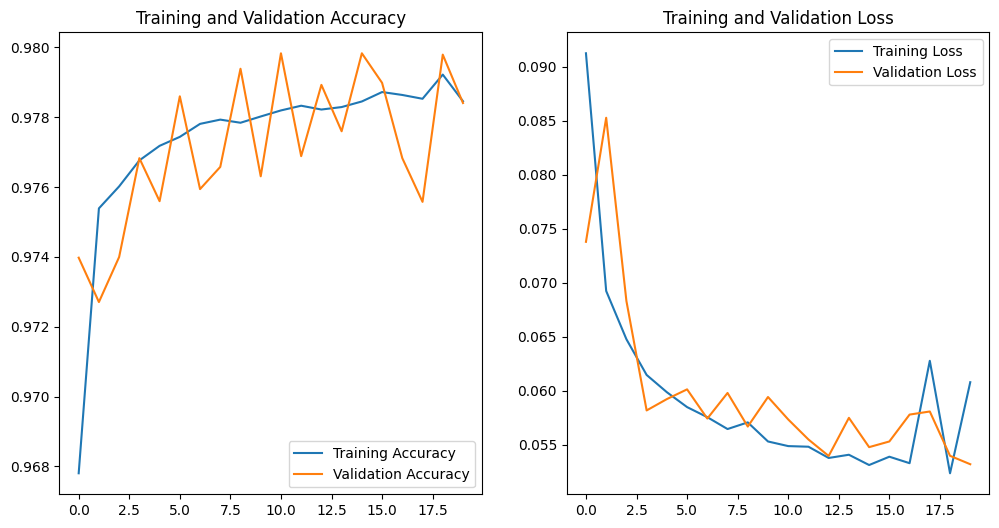

In [102]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']

loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('cic_cnn.png')
plt.show()

In [114]:
X_test_pca.shape

(36674, 24)

(36674, 24, 1)

In [118]:
X_test_reshaped_cnn = X_test_pca.reshape((X_test_pca.shape[0],X_test_pca.shape[1], 1))
test_dataset_cnn = tf.data.Dataset.from_tensor_slices((X_test_reshaped_cnn, y_test))

batch_size = 32
test_dataset_cnn = test_dataset_cnn.batch(batch_size)
test_dataset_cnn = test_dataset_cnn.prefetch(tf.data.experimental.AUTOTUNE)

In [119]:
X_test_reshaped_cnn.shape

(36674, 24, 1)

In [120]:
test_loss, test_accuracy = cnn_model.evaluate(test_dataset_cnn)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1147/1147 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9792 - loss: 0.0544
Test Loss: 0.05469876155257225
Test Accuracy: 0.9793041348457336


In [121]:
sample_input = X_test_reshaped_cnn[:1]  # Single test sample
cnn_model(sample_input)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.390848e-12]], dtype=float32)>

In [125]:
predictions_cnn = cnn_model.predict(test_dataset_cnn)


   1/1147 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step

1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [126]:
for i, pred in enumerate(predictions_cnn[:5]):  # Displaying the first 5 predictions
    print(f'Prediction {i+1}: {pred}')

Prediction 1: [4.671805e-12]
Prediction 2: [0.9999994]
Prediction 3: [0.]
Prediction 4: [0.8905741]
Prediction 5: [1.]


In [124]:
y_test[:5]

,Label
184229,0
211022,1
35457,0
145955,1
18792,1


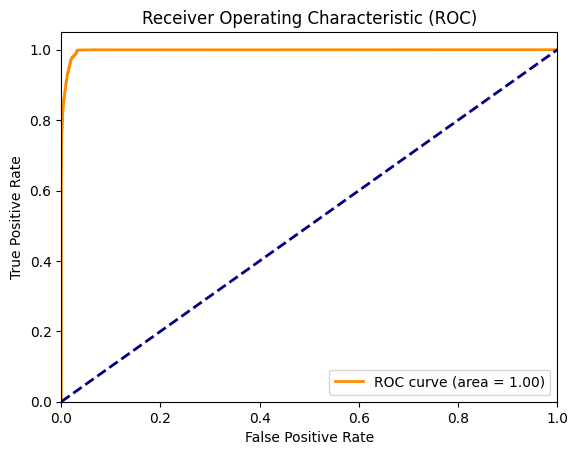

In [128]:
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, predictions_cnn)

# Step 4: Compute AUC (Area Under Curve) - Higher is better
roc_auc = auc(fpr_cnn, tpr_cnn)

# Step 5: Plot the ROC curve
plt.figure()
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('CIC_CNN_ROC.png')
plt.show()

In [129]:
j_scores_cnn = tpr_cnn - fpr_cnn
best_threshold_index = np.argmax(j_scores_cnn)
best_threshold_cnn = thresholds[best_threshold_index]

print(f'Best Threshold (Maximizing TPR - FPR): {best_threshold_cnn:.2f}')

Best Threshold (Maximizing TPR - FPR): 0.92


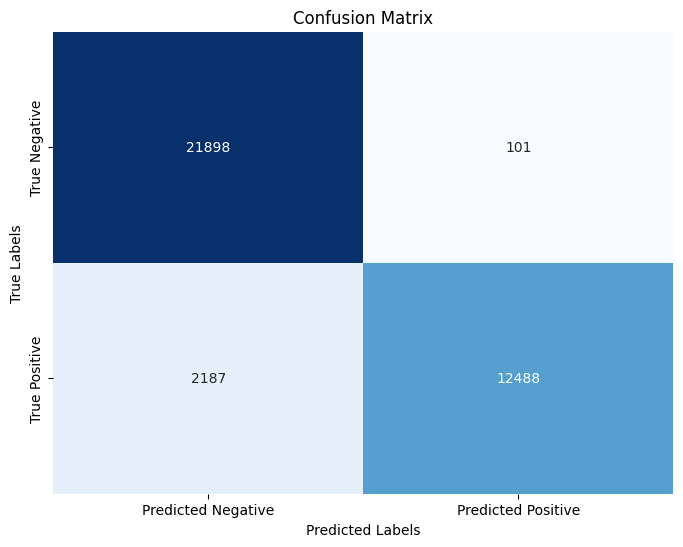

In [130]:
predicted_classes = np.where(predictions_cnn >= best_threshold_cnn, 1, 0)
cm = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('cic_cnn_conf_mat.png')
plt.show()

In [131]:
tn, fp, fn, tp = cm.ravel()

# Compute Metrics
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)
accuracy = accuracy_score(y_test, predicted_classes)
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# Print metrics
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Specificity: {specificity:.2f}')

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, predicted_classes))

Precision: 0.99
Recall: 0.85
F1 Score: 0.92
Accuracy: 0.94
Specificity: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     21999
           1       0.99      0.85      0.92     14675

    accuracy                           0.94     36674
   macro avg       0.95      0.92      0.93     36674
weighted avg       0.94      0.94      0.94     36674

